## Overview

In this exercise, I will review core concepts and implement Logistic Regression with regularization (in python), using the Stanford Machine Learning Online course; <i>Programming Exercise 2: Logistic Regression (Week 3)</i> to illustrate.

## Part 1: Dataset

The dataset for this part of the exercise consists of 118 examples, used to predict whether microchips from a fabrication plant pass quality assurance (QA) tests. The first two columns of each training example contain the scores each chip obtained on two QA tests, while the last column indicates whether or not the chip passed the test. We can load the dataset using numpy as follows: 

In [1]:
import numpy as np
from numpy import loadtxt

def load_data(input_file, delim=','):
    data = np.loadtxt(input_file, delimiter=delim)
    n_features = data.shape[1]-1 
    if n_features == 1: 
        X = data[:,0]
    else: 
        X = data[:,np.arange(n_features)]
    y = data[:,n_features]
    assert len(X) == len(y)
    print("Number of training examples: %i" % X.shape[0])
    print("Number of features: %i" % X.shape[1])
    
    return X, y

X, y = load_data("ex2data2.txt")
print(X.shape)

Number of training examples: 118
Number of features: 2
(118, 2)


We can visualize the dataset using matplotlib. 

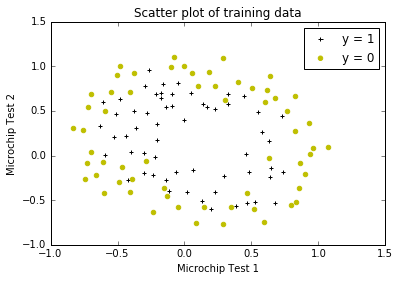

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title('Scatter plot of training data') 
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

x_pos = np.where(y == 1)
x_neg = np.where(y == 0)

adm = plt.scatter(X[x_pos][:,0], X[x_pos][:,1], marker='+', color='k')
not_adm = plt.scatter(X[x_neg][:,0], X[x_neg][:,1], marker='o', color='y')
plt.legend((adm, not_adm), ('y = 1', 'y = 0'), 
           scatterpoints=1, loc="upper right")
plt.show()

## Part 2: Training the Model

The figure shows that the data is not linearly separable, therefore a typical application of logistic regression might not create the best decision boundary to classify the data. Instead, we must adapt classical logistic regression to be able to create non-linear decision boundaries. One way to do this is to use more complex features. 

### Feature Mapping

One way to create more complex features is to make new features out of the existing features (i.e., polynomial features). For example, let's re-examine the hypothesis function from linear regression. 

$$h_{\theta}(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$$

For instance, we could add polynomial features and use the following more complex hypothesis

$$h_{\theta}(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_1 x_2 + \theta_4 x_1^2 + \theta_5 x_2^2 + \ldots, $$

which is no longer linear, but has multiple dimensions. In python we can perform this feature mapping as follows:

In [6]:
def mapFeatures(X1, X2, degree):
    X_map = np.matrix(np.ones(X1.shape[0])).T
    for i in range(1,degree+1):
        for j in range(i+1):
            poly_features = np.multiply(np.power(X1, i-j), 
                                        np.power(X2, j))
            X_map = np.c_[X_map, poly_features]
    return X_map

X, y = load_data("ex2data2.txt")
X = mapFeatures(X[:,0], X[:,1], degree=6)
print(X.shape)

Number of training examples: 118
Number of features: 2
(118, 28)


Adding polynomial features will likely enable the classifier to fit non-linear decision boundaries. However, the disavantage is that the classifier may become susceptible to overtraining, showing <b>high variance</b> when presented with unseen data. Essentially, the classifier may not generalize particularly well, but instead tend to fit the training data very well, performing poorly on unseen test data. To combat this <b>overfitting</b> problem, we can apply <b>regularization</b>. 

### Regularization

In machine learning, regularization is a technique for discounting certain features that are likely to unduly influence  training and lead to high variance models. To perform regularization, we inflate cost of each feature to be discounted, which in turn reduces the parameter $\theta$ for the given feature, making it small, but not eliminating the feature algother.  For example, we could discount the cost of features 3, 4, and 5, by including a multiplier of 1000 to feature 3 ($x_1 x_2$), feature 4 ($x_1^2$), and feature 5 ($x_2^2$) as follows

$$J(\theta) = \frac{1}{m} \sum_{i=1}^m  [- y^{(i)} \log(g(h_{\theta}(x^{(i)}))) - (1 - y^{(i)}) \log(1 - g(h_{\theta}(x^{(i)})))] + 1000 \cdot \theta_3 + 1000 \cdot \theta_4  + 1000 \cdot \theta_5.$$


### Cost Function

More generally, we can regularize all parameters of the logistic regression model (except the bias) by using a standard multiplier, as follows 

$$J(\theta) = \frac{1}{m} \sum_{i=1}^m  [- y^{(i)} \log(g(h_{\theta}(x^{(i)}))) - (1 - y^{(i)}) \log(1 - g(h_{\theta}(x^{(i)})))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2.$$


The multiplier $\lambda$ is called the <b>regularization parameter</b> and $j$ is the index of the $j^{th}$ feature. In python, we can implement this regularized cost function as follows:

In [7]:
def sigmoid_hypothesis(z):
    return 1/(1 + np.exp(-z))

def compute_cost_reg(theta, X, y, lmbda=1):
    theta = theta.reshape(X.shape[1],1)
    m = float(X.shape[0])
    z = X * theta
    g = sigmoid_hypothesis(z)
    
    cost = 1./float(m) * (-y.T.dot(np.log(g)) - (1 - y).T.dot(np.log(1 - g)))
    J = cost + lmbda/(2*m) * np.sum(np.square(theta))
    return J
    
X, y = load_data("ex2data2.txt")
X = mapFeatures(X[:,0], X[:,1], degree=6)
#X = np.c_[np.ones(len(X)), X]
initial_theta = np.zeros((X.shape[1], 1))

y = y.reshape(X.shape[0], 1)
J = compute_cost_reg(initial_theta, X, y)
print("Initial Cost: %.3f" % J)

Number of training examples: 118
Number of features: 2
Initial Cost: 0.693


### Optimization/Minimization

Given this regularized cost function, we can compute the <b>regularized gradient</b> as the partial derivative of the cost function as follows: 

$$\frac{\delta}{\delta \theta_j} J(\theta) = \frac{1}{m} \sum_{i=1}^m (x^{(i)}) (g(h_{\theta}(x^{(i)})) - y^{(i)})+ \frac{\lambda}{m} \sum_{j=1}^n \theta_j.$$ 

The vectorized version of this regularized gradient is therefore

$$\frac{\delta}{\delta \Theta} J(\Theta) = \frac{1}{m} X^T (g(\Theta^T X) - Y)+ \frac{\lambda}{m} \Theta.$$


In python, this regularized gradient can be computed as follows:

In [8]:
def compute_gradient_reg(theta, X, y, lmbda=1):
    z = X.dot(theta)
    g = sigmoid_hypothesis(z)
    loss = np.subtract(g, y)
    return (X.T.dot(loss) + lmbda * theta)/float(X.shape[0])

grad = compute_gradient_reg(initial_theta, X, y)

Using this gradient, the optimal values for theta can then be computed using gradient descent

$$\theta_j = \theta_j - \alpha \frac{\delta}{\delta \theta_j} J(\theta).$$

In [29]:
import sys

def gradient_descent_reg(theta, X, y, alpha=4.8, lmbda=1, max_iter=400):
    best_theta = theta
    min_cost = sys.maxsize
    J_hist = np.zeros(max_iter)
    grad_hist = list()
    
    for i in np.arange(max_iter):
        grad = compute_gradient_reg(theta, X, y, lmbda)
        grad_hist.append(grad)
        theta = theta - (alpha * grad)
        
        J = compute_cost_reg(theta, X, y, lmbda)
        J_hist[i] = J
        if J < min_cost:
            min_cost = J
            best_theta = theta
    return best_theta, min_cost, J_hist, grad_hist

X, y = load_data("ex2data2.txt")
X = mapFeatures(X[:,0], X[:,1], degree=6)
#X = np.c_[np.ones(len(X)), X]
initial_theta = np.zeros((X.shape[1], 1))
y = y.reshape(X.shape[0], 1)

theta, min_cost, J_hist, grad_hist = gradient_descent_reg(initial_theta, X, y, 0.01, 10)
print("Minimum gradient %s" % theta.T)
print("Minimum cost %s" % min_cost)

Number of training examples: 118
Number of features: 2
Minimum gradient [[ 0.03416517 -0.04189799  0.02795678 -0.14738001 -0.03766206 -0.09674944
  -0.04698362 -0.02037844 -0.02418191 -0.05591858 -0.11794334 -0.00645076
  -0.03822671 -0.01001774 -0.10875732 -0.05544831 -0.01278985 -0.00951324
  -0.01702599 -0.01395248 -0.08315177 -0.09295256 -0.00278329 -0.01919807
  -0.00099426 -0.02165711 -0.0044489  -0.10899685]]
Minimum cost [[ 0.66634679]]


And as previously done, we can use an advanced optimization algorithm such as fminunc as follows:

In [24]:
import scipy.optimize as op

options = {'full_output': True}

X, y = load_data("ex2data2.txt")
X = mapFeatures(X[:,0], X[:,1], degree=6)
y = y.reshape(X.shape[0], 1)

initial_theta = np.zeros((X.shape[1], 1))

lmbda = 1
theta, cost, _, _, _ = \
        op.fmin(lambda t: compute_cost_reg(t, X, y, lmbda), initial_theta, **options)
 
print("Cost=%.3f, lambda=%f" % (cost, lmbda))

Number of training examples: 118
Number of features: 2
Cost=0.614, lambda=1.000000


Given the optimal parameters, we can then plot the decision boundary by updating our original function to deal with more than two variables as follows. 

## Part 3: Prediction

In [30]:
from sklearn.metrics import precision_score

def predict(theta, X):
    y_pred = np.zeros((X.shape[0], 1))
    h = X.dot(theta)
    g = sigmoid_hypothesis(h)
    x_pos = np.where(g >= 0.5)
    y_pred[x_pos] = 1
    return y_pred

X, y = load_data("ex2data2.txt")
X = mapFeatures(X[:,0], X[:,1], degree=6)
y = y.reshape(X.shape[0], 1)
theta = theta.reshape(X.shape[1], 1)

y_pred = predict(theta, X)

print("Precision: %.2f" % precision_score(y.T, y_pred.T,average='micro'))

Number of training examples: 118
Number of features: 2
Precision: 0.81


The learned weights can be used to plot the decision boundary for various values of lambda. For $lambda = 1$ for example, 

Number of training examples: 118
Number of features: 2


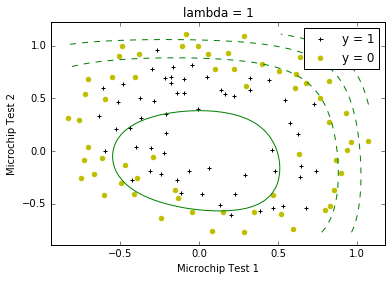

In [31]:
plt.title('lambda = %s' % lmbda)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

degree=6
X, y = load_data("ex2data2.txt")
x_pos = np.where(y == 1)
x_neg = np.where(y == 0)

adm = plt.scatter(X[x_pos][:,0], X[x_pos][:,1], marker='+', color='k')
not_adm = plt.scatter(X[x_neg][:,0], X[x_neg][:,1], marker='o', color='y')

X = mapFeatures(X[:,0], X[:,1], degree)
xvals = np.linspace(np.min(X[:,1]),np.max(X[:,1]),num=50).reshape(50, 1)
yvals = np.linspace(np.min(X[:,2]),np.max(X[:,2]),num=50).reshape(50, 1)
z = np.zeros((len(xvals),len(yvals)))

for i in range(len(xvals)):
    for j in range(len(yvals)):
        z[i,j] = mapFeatures(np.matrix(xvals[i]),np.matrix(yvals[j]),degree)*theta

mX, mY = np.meshgrid(xvals, yvals);
plt.contour(mX, mY, z, linewidth=1, colors='g');
plt.legend((adm, not_adm), ('y = 1', 'y = 0'), scatterpoints=1, loc="upper right")
plt.show()